In [116]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.settings.figdir = 'figures'  # Directory to save figures
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(6, 6)) 

## Step 1: Initialize data

In [117]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'neurips' / 'neurips_train.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['cell_type'],
                    'conditioning_covariate': 'cell_type',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'target_max': 1,
                    'target_min': -1,
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.10],
                    'cov_embedding_dimensions': 256}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"])

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

n_cat = len(dataset.id2cov["cell_type"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Step 2: Initialize encoder

In [118]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 50],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/off_train_autoencoder_neurips_whole_genome/eabc6534-947b-4486-8012-c9e351b297ca/checkpoints/epoch_59.ckpt"

In [119]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

encoder_model.eval()

EncoderModel(
  (x0_from_x): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=14087, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (2): Linear(in_features=256, out_features=50, bias=True)
    )
  )
  (x_from_x0): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=50, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_runnin

## Step 3: Initialize FM model

In [120]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.0001
                        }

In [121]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/off_fm_resnet_autoencoder_neurips_whole_genome/8117877a-f196-4142-a528-2ecdd6294151/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [122]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 0.0335, -0.1560, -0.5291,  ...,  0.3735, -0.0941, -0.8921],
        [-0.7772,  0.1002,  0.2768,  ..., -0.9797,  0.9892, -0.2922],
        [-0.1416, -0.6285, -1.9562,  ..., -0.4058,  1.5861, -1.3475],
        ...,
        [ 1.1412, -1.0427, -0.4340,  ...,  0.5399, -1.1693,  0.6423],
        [-0.2317, -0.1948,  0.5764,  ...,  1.3119, -2.3207,  0.7109],
        [-1.7751,  1.2498,  1.1430,  ..., -1.6456,  0.3279,  0.6074]],
       device='cuda:0', requires_grad=True)


Initializations

In [123]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=512,
            size_factor_statistics=size_factor_statistics,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=14087, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=50, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=50, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
         

## Read original data 

In [154]:
adata_original = sc.read_h5ad(DATA_DIR / 'processed_full_genome' / 'neurips' / 'neurips_test.h5ad')
adata_original.X = adata_original.layers["X_counts"].copy()
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [125]:
adata_original

AnnData object with n_obs × n_vars = 18053 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'size_factor'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'dataset_id', 'genome', 'log1p', 'neighbors', 'organism', 'pca', 'umap'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'connectivities', 'distances'

In [126]:
unique_classes = np.unique(adata_original.obs.cell_type, return_counts=True)
unique_classes = dict(zip(unique_classes[0], unique_classes[1]))
unique_classes

{'B1 B IGKC+': 167,
 'B1 B IGKC-': 120,
 'CD14+ Mono': 4360,
 'CD16+ Mono': 552,
 'CD4+ T CD314+ CD45RA+': 21,
 'CD4+ T activated': 1409,
 'CD4+ T activated integrinB7+': 200,
 'CD4+ T naive': 1185,
 'CD8+ T CD49f+': 154,
 'CD8+ T CD57+ CD45RA+': 276,
 'CD8+ T CD57+ CD45RO+': 294,
 'CD8+ T CD69+ CD45RA+': 139,
 'CD8+ T CD69+ CD45RO+': 181,
 'CD8+ T TIGIT+ CD45RA+': 207,
 'CD8+ T TIGIT+ CD45RO+': 226,
 'CD8+ T naive': 620,
 'CD8+ T naive CD127+ CD26- CD101-': 5,
 'Erythroblast': 805,
 'G/M prog': 398,
 'HSC': 337,
 'ILC': 47,
 'ILC1': 112,
 'Lymph prog': 361,
 'MAIT': 148,
 'MK/E prog': 123,
 'NK': 1103,
 'NK CD158e1+': 430,
 'Naive CD20+ B IGKC+': 786,
 'Naive CD20+ B IGKC-': 408,
 'Normoblast': 297,
 'Plasma cell IGKC+': 52,
 'Plasma cell IGKC-': 43,
 'Plasmablast IGKC+': 50,
 'Plasmablast IGKC-': 19,
 'Proerythroblast': 292,
 'Reticulocyte': 835,
 'T prog cycling': 1,
 'T reg': 112,
 'Transitional B': 300,
 'cDC1': 1,
 'cDC2': 344,
 'dnT': 6,
 'gdT CD158b+': 137,
 'gdT TCRVD2+': 42,


## Generate and save cells

In [127]:
X_generated_list = []
classes_str = []
for _ in tqdm(range(18)):
    num_indices =1000
    index_range = len(adata_original)
    
    # Generate random dummy indices without replacement
    indices = random.sample(range(index_range), num_indices)
    adata_indices = adata_original[indices]
    
    classes =  list(adata_indices.obs.cell_type)
    classes_str += classes
    classes = torch.tensor([dataset.id2cov["cell_type"][c] for  c in classes])

    log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()
    X_generated = generative_model.batched_sample(batch_size=100,
                                                repetitions=10,
                                                n_sample_steps=2, 
                                                covariate="cell_type", 
                                                covariate_indices=classes, 
                                                log_size_factor=log_size_factors)

    X_generated_list.append(X_generated.to("cpu"))

100%|██████████| 18/18 [00:27<00:00,  1.52s/it]


In [128]:
X_generated = torch.cat(X_generated_list, dim=0)

### Generate single condition

In [129]:
# dataset.id2cov["cell_type"]

In [130]:
# # Normal sampling
# condition_name = "Plasmablast IGKC-"
# condition_val = dataset.id2cov["cell_type"][condition_name]
# adata_cond = adata_original[adata_original.obs.cell_type==condition_name]
# n_to_generate = adata_cond.shape[0]

# classes = condition_val*torch.ones(n_to_generate).long()
# classes_str = [condition_name for _ in range(n_to_generate)]


# log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()
# X_generated = generative_model.sample(batch_size=n_to_generate,
#                                         n_sample_steps=100, 
#                                         covariate="cell_type", 
#                                         covariate_indices=classes, 
#                                         log_size_factor=log_size_factors)

# X_generated_list= X_generated.to("cpu")

In [131]:
# # Oversample
# condition_name = "B1 B IGKC-"
# condition_val = dataset.id2cov["cell_type"][condition_name]
# adata_cond = adata_original[adata_original.obs.cell_type==condition_name]
# n_to_generate = adata_cond.shape[0]

# classes = condition_val*torch.ones(n_to_generate*2).long()
# classes_str = [condition_name for _ in range(n_to_generate*2)]

# log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda().repeat(2,1)

# X_generated = generative_model.sample(batch_size=n_to_generate*2,
#                                         n_sample_steps=100, 
#                                         covariate="cell_type", 
#                                         covariate_indices=classes, 
#                                         log_size_factor=log_size_factors)

# X_generated_list= X_generated.to("cpu")

**Create adata and check plots**

In [132]:
adata_generated = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated).cpu().numpy()))

adata_generated.obs["size_factor"] = adata_generated.X.sum(1)
adata_generated.obs["cell_type"] = classes_str
adata_generated.obs["cell_type"] = adata_generated.obs["cell_type"].astype("category")
adata_generated.layers["X_counts"] = adata_generated.X.copy()

In [133]:
sc.pp.normalize_total(adata_generated, target_sum=10000)
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


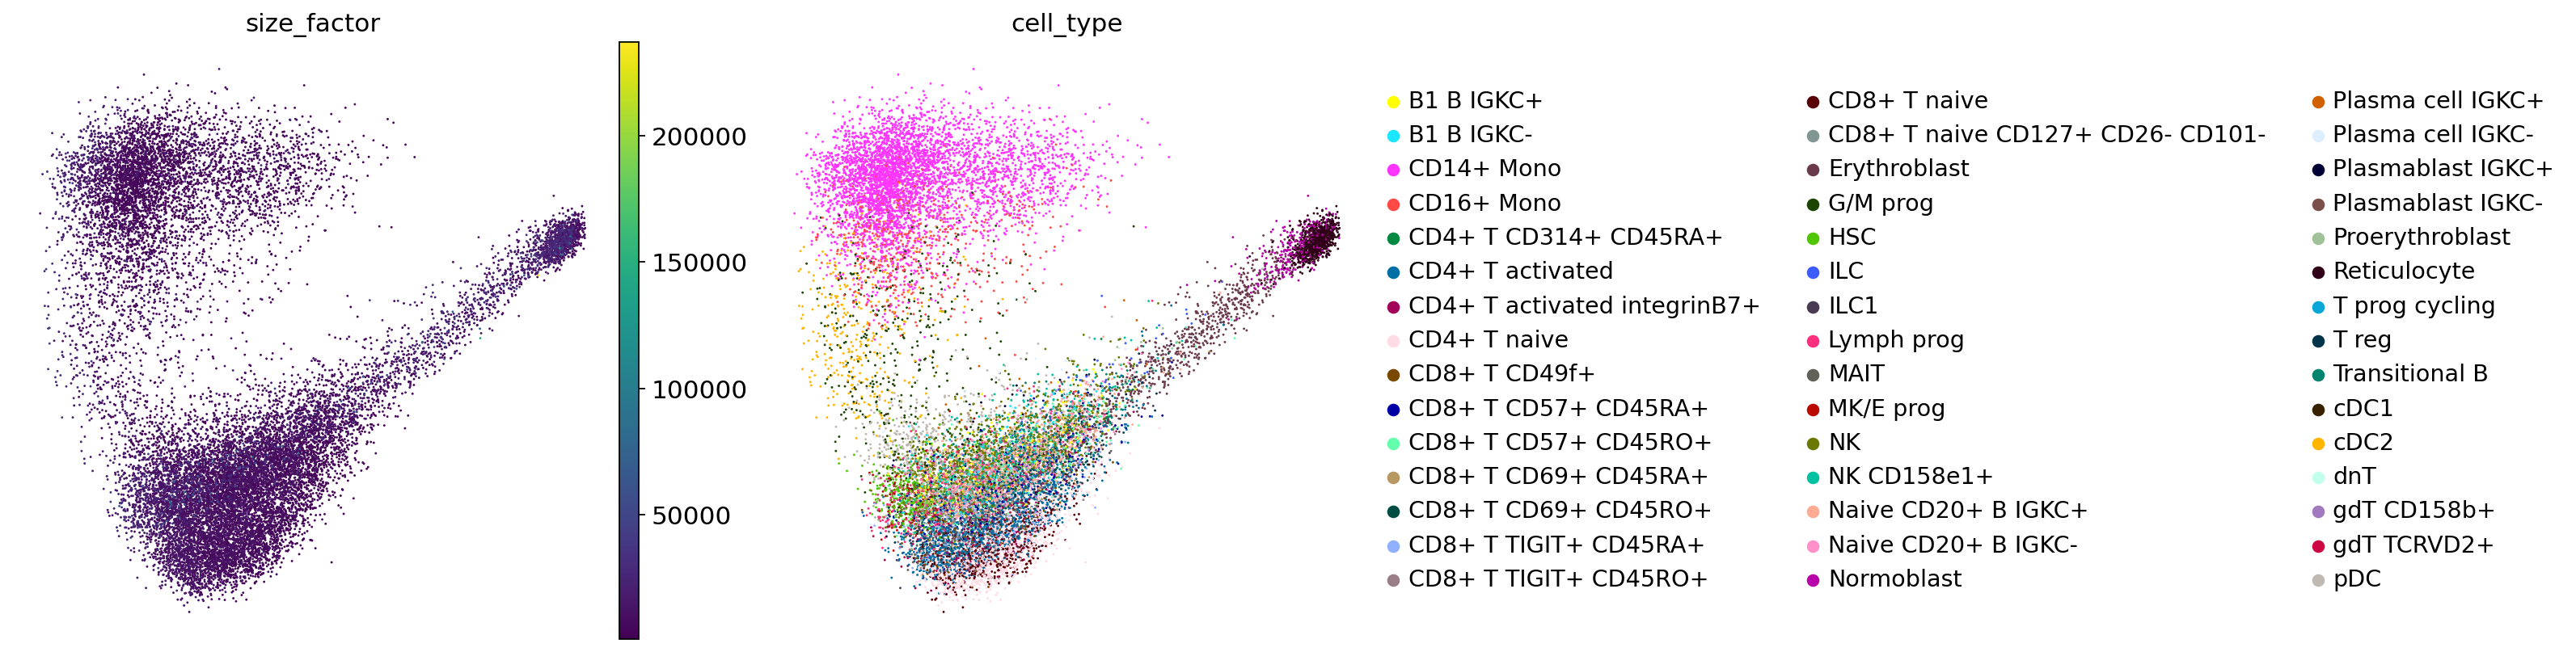

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


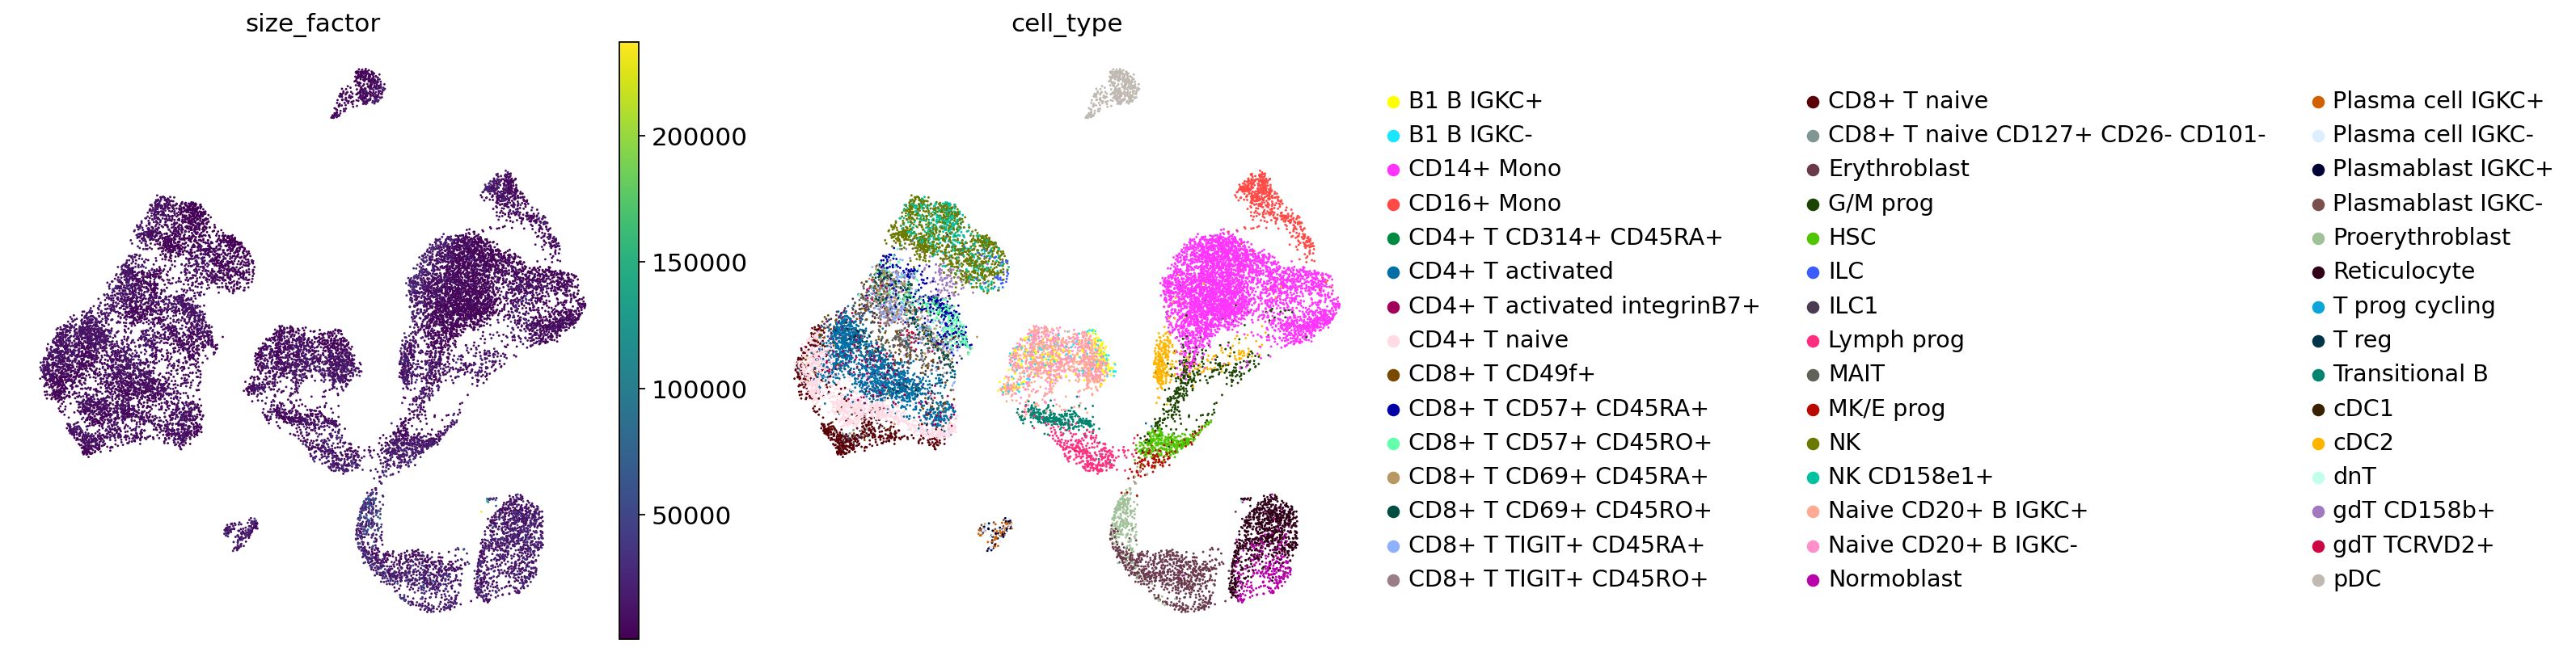

In [134]:
sc.pl.pca(adata_generated, color=["size_factor", "cell_type"], annotate_var_explained=True)
sc.pl.umap(adata_generated, color=["size_factor", "cell_type"])

## Preprocess real data object

In [157]:
sc.pp.normalize_total(adata_original, target_sum=10000)
sc.pp.log1p(adata_original)
sc.tl.pca(adata_original)
sc.pp.neighbors(adata_original)
sc.tl.umap(adata_original)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


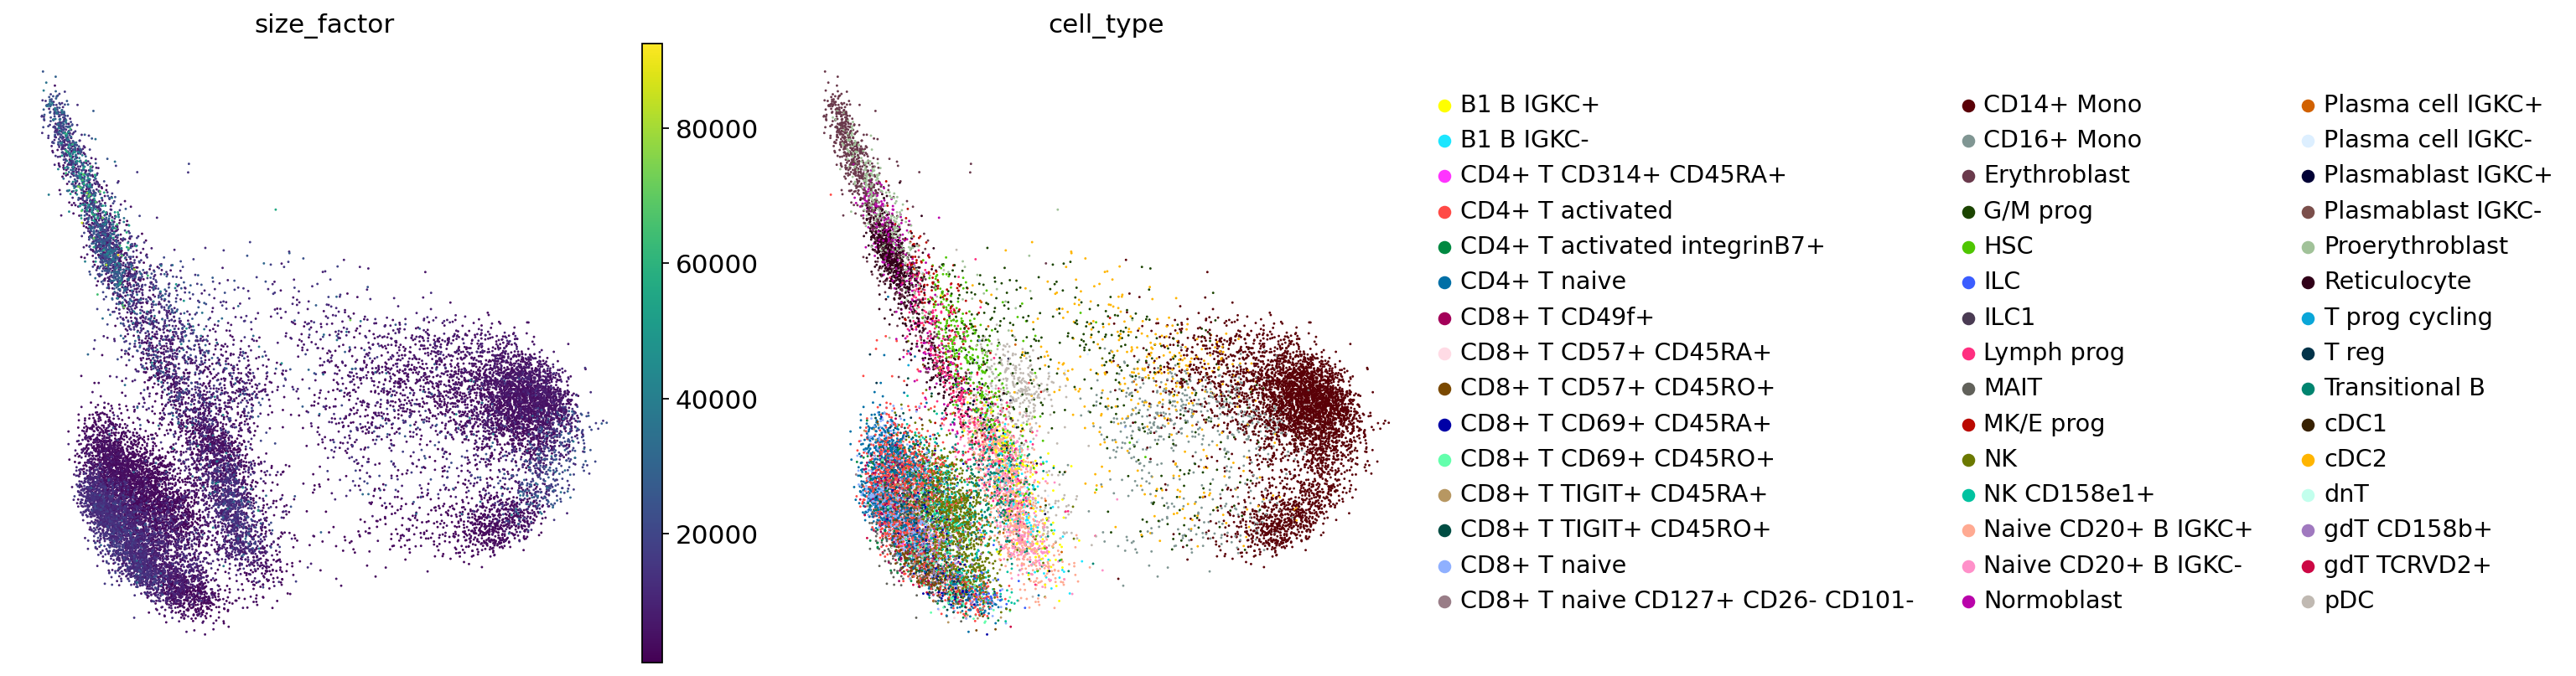

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


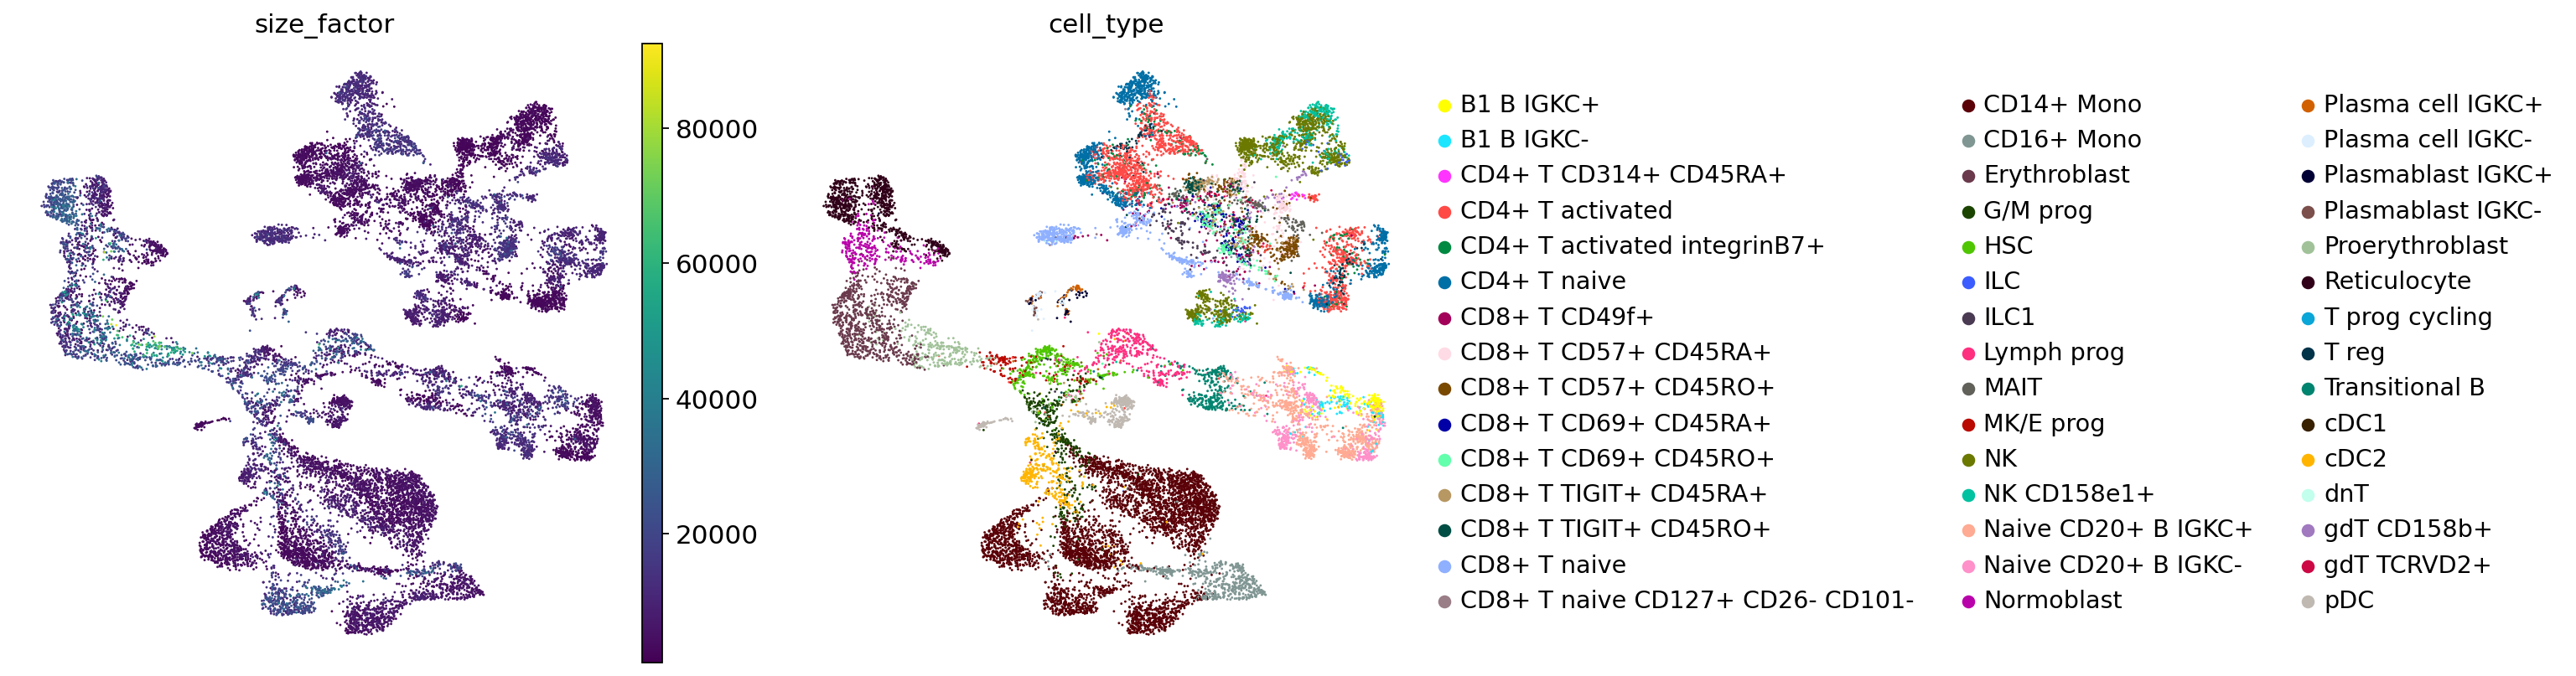

In [136]:
sc.pl.pca(adata_original, color=["size_factor", "cell_type"], annotate_var_explained=True)
sc.pl.umap(adata_original, color=["size_factor", "cell_type"])

In [137]:
# adata_generated.write_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/generated/neurips.h5ad")

Merge and plot the generated and real data

In [138]:
dataset_type = ["Real" for _ in range(adata_original.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]
dataset_type["cell_type"] = list(adata_original.obs.cell_type)+list(classes_str)

In [139]:
adata_merged = sc.AnnData(X=torch.cat([torch.tensor(adata_original.X.A), torch.tensor(adata_generated.X.A)], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [140]:
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


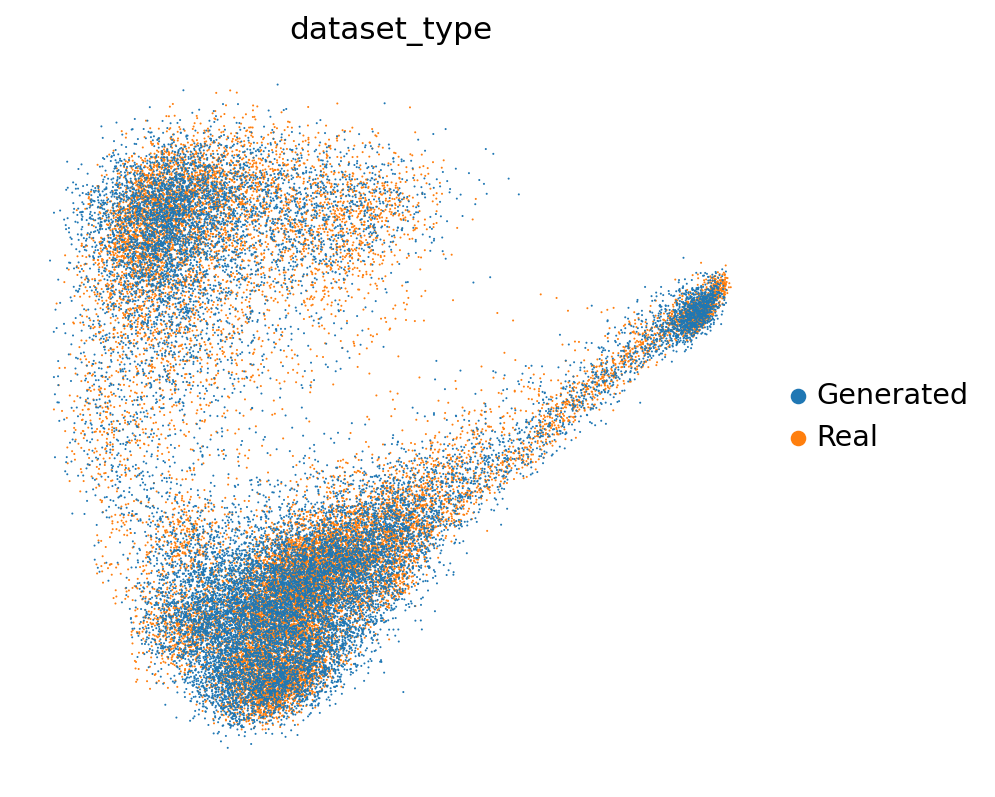

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


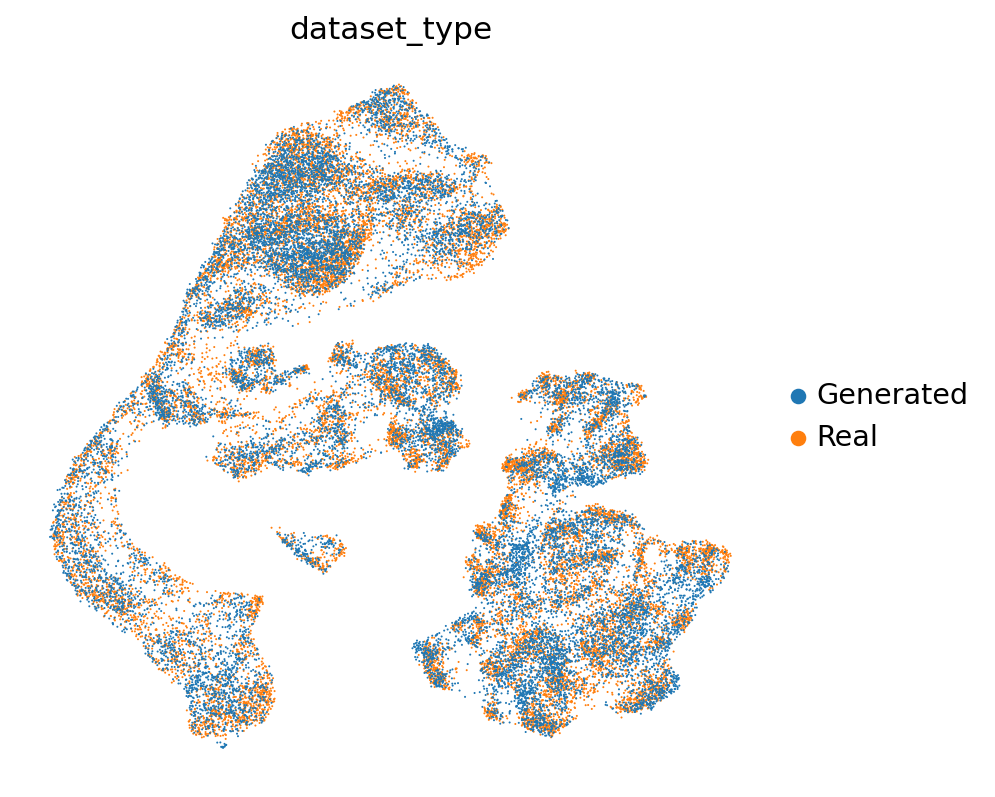

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


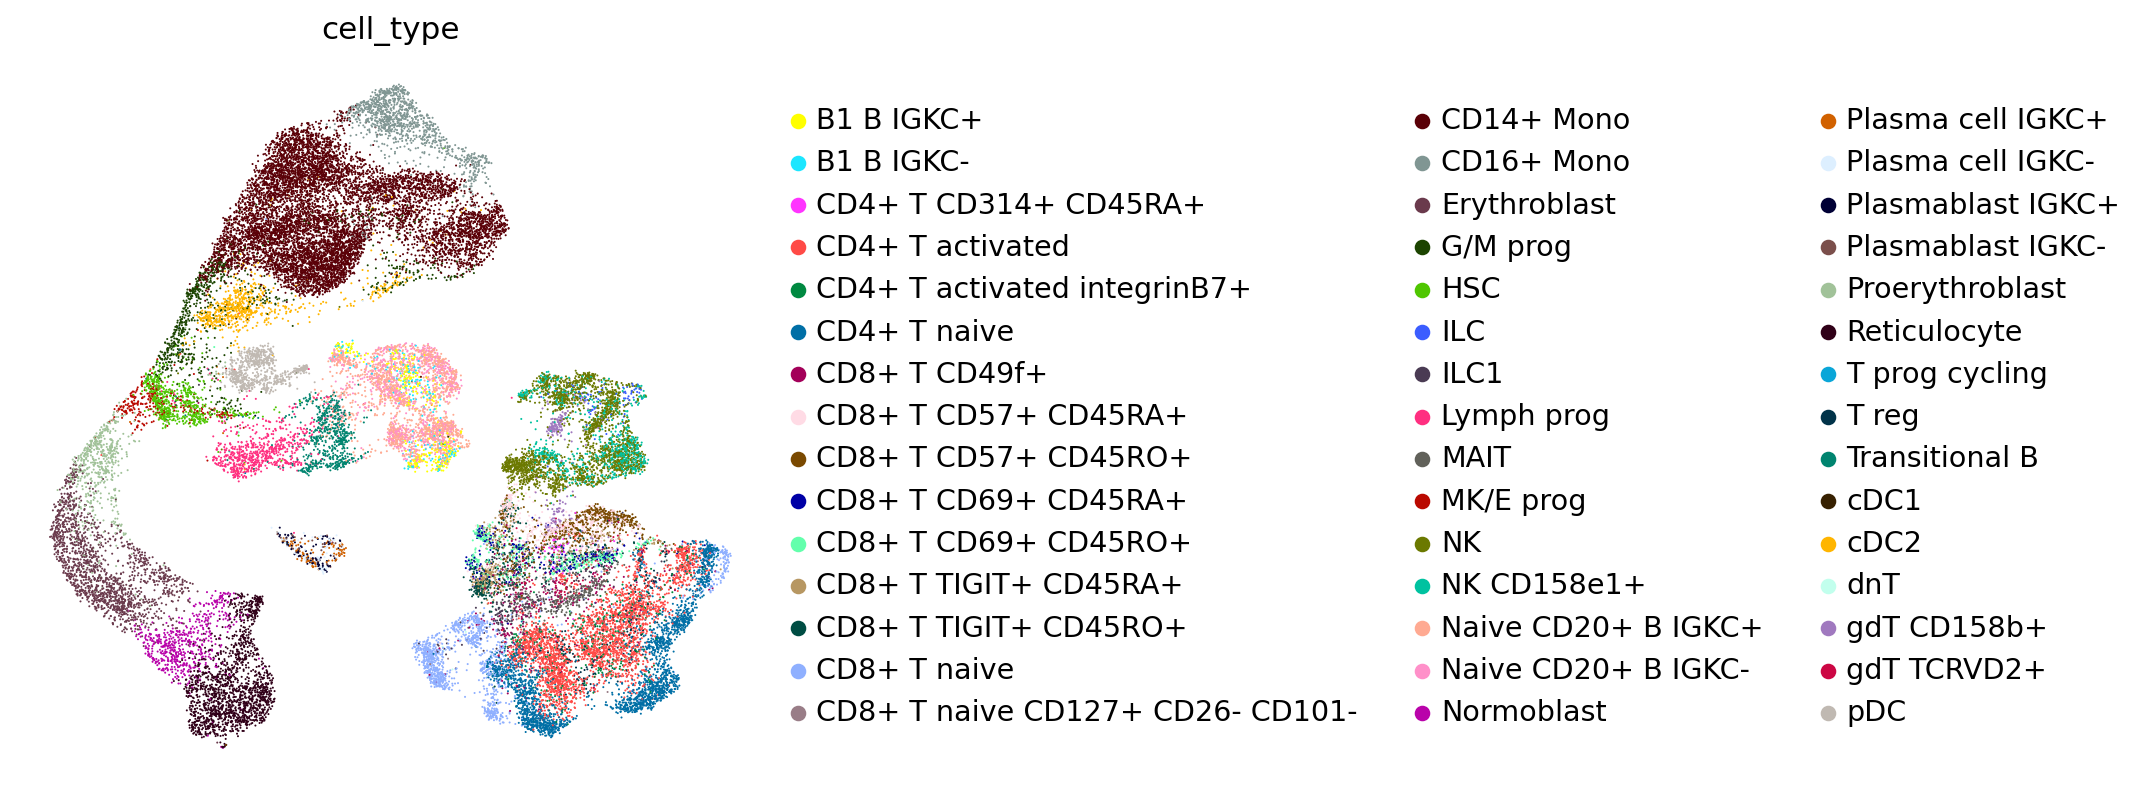

In [159]:
sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color="dataset_type")
sc.pl.umap(adata_merged, color="cell_type")

## Check augmented rare class

In [142]:
# sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color=["classes"], s=10, groups="B1 B IGKC-")

In [143]:
# sc.pl.umap(adata_merged, color=["classes"], s=10, groups="B1 B IGKC-")

In [144]:
# adata_merged.var = adata_original.var
# adata_merged.var_names_make_unique()

## Markers

In [145]:
# ct_to_plot = "B1 B IGKC-"

In [146]:
# marker_genes = ['IGKC']

In [33]:
# import scanpy as sc

# # Assuming adata_merged is your AnnData object
# sc.settings.set_figure_params(figsize=(4, 4))  # Set the figsize parameter to make the plot smaller

# # Plot the violin plot
# sc.pl.violin(adata_merged[adata_merged.obs.classes == ct_to_plot], groupby="dataset_type", keys=marker_genes)

## Sparsity

In [34]:
# # Separate the number of zero genes for real and generated cells
# import seaborn as sns

# real_cells_zeros = list((adata_original.X.A==0).sum(1))
# generated_cells_zeros = list((adata_generated.X.A==0).sum(1))

# # Create a DataFrame for plotting with Seaborn
# df = pd.DataFrame({
#     'Number of zeros per cell': real_cells_zeros+generated_cells_zeros,
#     'Dataset type': ["Real" for _ in range(len(real_cells_zeros))] + ["Generated" for _ in range(len(generated_cells_zeros))]
# })

# # Plot histogram using Seaborn
# plt.figure(figsize=(4, 4))
# sns.histplot(data=df, x='Number of zeros per cell', hue='Dataset type', element='step', bins=50, kde=True)
# plt.xlabel('Number of Zero Genes')
# plt.ylabel('Frequency')
# plt.title('Overlap in Number of Zero Genes between Real and Generated Cells')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

## Overdispersion

In [35]:
# real_cells_mean_unfiltered = adata_original.X.A.mean(0)
# real_cells_mean=list(real_cells_mean_unfiltered[real_cells_mean_unfiltered<2])
# generated_cells_mean_unfiltered = adata_generated.X.A.mean(0)
# generated_cells_mean=list(generated_cells_mean_unfiltered[generated_cells_mean_unfiltered<2])

# real_cells_var = list(adata_original.X.A.var(0)[real_cells_mean_unfiltered<2])
# generated_cells_var = list(adata_generated.X.A.var(0)[generated_cells_mean_unfiltered<2])

# # Create a DataFrame for plotting with Seaborn
# df = pd.DataFrame({
#     'Mean': real_cells_mean+generated_cells_mean,
#     'Variance': real_cells_var+generated_cells_var,
#     'Dataset_type': ["Real" for _ in range(len(real_cells_mean))] + ["Generated" for _ in range(len(generated_cells_mean))]
# })

# # Plot histogram using Seaborn
# # Plot mean expression vs variance using Seaborn
# plt.figure(figsize=(10, 6))
# sns.lmplot(data=df, x='Mean', y='Variance', hue='Dataset_type',order=3, scatter_kws={'s': 10})
# plt.xlabel('Mean Expression')
# plt.ylabel('Variance')
# plt.title('Mean Expression vs Variance for Real and Generated Cells')
# # plt.legend()
# plt.show()